In [1]:
# 加载数据
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_set = load('train_set')
    train_label = load('train_label')
    # 测试集
    test_set = load('test_set')
    test_label = load('test_label')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_set, train_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_set, test_label),
                                  batch_size=batch_size, num_workers=workers, drop_last=True)
    return train_loader, test_loader

batch_size = 1
# 加载数据
train_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(test_loader))

91
39


In [2]:
# 定义 LSTMModel 模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes, output_dim):
        """
        预测任务  params:
        input_dim        : 输入数据的维度
        hidden_layer_size: 隐层的数目和维度
        output_dim       : 输出维度
        """
        super().__init__()
        # lstm层数
        self.num_layers = len(hidden_layer_sizes)
        self.lstm_layers = nn.ModuleList()  # 用于保存LSTM层的列表

        # 定义第一层LSTM   
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_layer_sizes[0], batch_first=True))
        
        # 定义后续的LSTM层
        for i in range(1, self.num_layers):
                self.lstm_layers.append(nn.LSTM(hidden_layer_sizes[i-1], hidden_layer_sizes[i], batch_first=True))
                
        # 定义线性层
        self.linear  = nn.Linear(hidden_layer_sizes[-1], output_dim)

       
    def forward(self, input_seq):  
        # 前向传播的过程是输入->LSTM层->全连接层->输出
        # 在观察查看LSTM输入的维度，LSTM的第一个输入input_size维度是(batch, seq_length, dim) batch是batch size , seq_length是序列长度，dim是输入维度，也就是变量个数
        # LSTM的第二个输入是一个元组，包含了h0,c0两个元素，这两个元素的维度都是（D∗num_layers,N,out)，
        # D=1表示单向网络，num_layers表示多少个LSTM层叠加，N是batch size，out表示隐层神经元个数

        # 输入形状，适应网络输入[batch, seq_length, dim]
        # 使用 permute 方法进行维度变换， 实现了维度的变换，而不改变数据的顺序
        lstm_out = input_seq
        for lstm in self.lstm_layers:
            lstm_out, _= lstm(lstm_out)  ## 进行一次LSTM层的前向传播
        # print(lstm_out.size())  # torch.Size([1, 1, 64])
        predict = self.linear(lstm_out[:, -1, :]) # torch.Size([1, 64]  # 仅使用最后一个时间步的输出 
        return predict

In [3]:
# 定义模型参数
input_dim = 1   # 输入维度为1维数据
hidden_layer_sizes = [32, 64] # LSTM隐藏层
output_dim = 1 # 输出维度为 1

model = LSTMModel(input_dim, hidden_layer_sizes, output_dim)  

# 定义损失函数和优化函数 
loss_function = nn.MSELoss()  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

   128
  4096
   128
   128
  8192
 16384
   256
   256
    64
     1
______
 29633


In [4]:
print(model)

LSTMModel(
  (lstm_layers): ModuleList(
    (0): LSTM(1, 32, batch_first=True)
    (1): LSTM(32, 64, batch_first=True)
  )
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


Epoch:  1 train_MSE-Loss: 0.78580613
Epoch:  1 test_MSE_Loss:1.56046224
Epoch:  2 train_MSE-Loss: 0.74044946
Epoch:  2 test_MSE_Loss:1.60792347
Epoch:  3 train_MSE-Loss: 0.66679357
Epoch:  3 test_MSE_Loss:1.60521636
Epoch:  4 train_MSE-Loss: 0.53562851
Epoch:  4 test_MSE_Loss:1.48034568
Epoch:  5 train_MSE-Loss: 0.36051610
Epoch:  5 test_MSE_Loss:1.20149676
Epoch:  6 train_MSE-Loss: 0.20678173
Epoch:  6 test_MSE_Loss:0.86044278
Epoch:  7 train_MSE-Loss: 0.10628579
Epoch:  7 test_MSE_Loss:0.55966256
Epoch:  8 train_MSE-Loss: 0.05304077
Epoch:  8 test_MSE_Loss:0.34622561
Epoch:  9 train_MSE-Loss: 0.03394648
Epoch:  9 test_MSE_Loss:0.22377259
Epoch: 10 train_MSE-Loss: 0.03053945
Epoch: 10 test_MSE_Loss:0.16229952
Epoch: 11 train_MSE-Loss: 0.02951804
Epoch: 11 test_MSE_Loss:0.12956293
Epoch: 12 train_MSE-Loss: 0.02775795
Epoch: 12 test_MSE_Loss:0.10845836
Epoch: 13 train_MSE-Loss: 0.02597217
Epoch: 13 test_MSE_Loss:0.09292362
Epoch: 14 train_MSE-Loss: 0.02456491
Epoch: 14 test_MSE_Loss:0.0

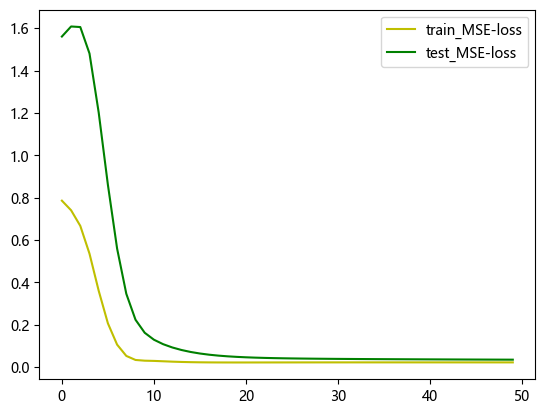

min_MSE: 0.03531192389961619


In [5]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(epochs, model, optimizer, loss_function, train_loader, test_loader, device):
    model = model.to(device)

    # 最低MSE  
    minimum_mse = 1000.
    # 最佳模型
    best_model = model

    train_mse = []     # 记录在训练集上每个epoch的 MSE 指标的变化情况   平均值
    test_mse = []      # 记录在测试集上每个epoch的 MSE 指标的变化情况   平均值
   
  # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
         # 训练
        model.train()

        train_mse_loss = []    #保存当前epoch的MSE loss和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 损失计算
            loss = loss_function(y_pred, labels)
            train_mse_loss.append(loss.item()) # 计算 MSE 损失
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算总损失
        train_av_mseloss = np.average(train_mse_loss) # 平均
        train_mse.append(train_av_mseloss)

        print(f'Epoch: {epoch+1:2} train_MSE-Loss: {train_av_mseloss:10.8f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            # 将模型设置为评估模式
            model.eval()
            test_mse_loss = []    #保存当前epoch的MSE loss和
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 计算损失
                test_loss = loss_function(pre, label)
                test_mse_loss.append(test_loss.item()) 
            
            # 计算总损失
            test_av_mseloss = np.average(test_mse_loss) # 平均
            test_mse.append(test_av_mseloss)
            print(f'Epoch: {epoch+1:2} test_MSE_Loss:{test_av_mseloss:10.8f}')
            # 如果当前模型的 MSE 低于于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if test_av_mseloss < minimum_mse:
                minimum_mse = test_av_mseloss
                best_model = model# 更新最佳模型的参数
         
    # 保存最后的参数
    # torch.save(model, 'final_model_lstm.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_lstm.pt')
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    
    # 可视化
    plt.plot(range(epochs), train_mse, color = 'y',label = 'train_MSE-loss')
    plt.plot(range(epochs), test_mse, color = 'g',label = 'test_MSE-loss')
    plt.legend()
    plt.show()   #显示 lable 
    print(f'min_MSE: {minimum_mse}')


#  模型训练
epochs = 50
model_train(epochs, model, optimizer, loss_function, train_loader, test_loader, device)

# 预测可视化与评估

### 第一部分，训练集可视化与评估

In [6]:
# 模型预测
# 模型 测试集 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_lstm.pt')
model = model.to(device)

# 预测数据
train_data = []
train_pre_data = []
with torch.no_grad():
        for data, label in train_loader:
            # 原始标签
            origin_lable = label.tolist()
            train_data += origin_lable
            model.eval()  # 将模型设置为评估模式
            
            # 预测
            data, label = data.to(device), label.to(device)
            train_pred = model(data)  # 对测试集进行预测
            train_pred = train_pred.tolist()
            train_pre_data += train_pred      

c:\Users\许艺馨\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


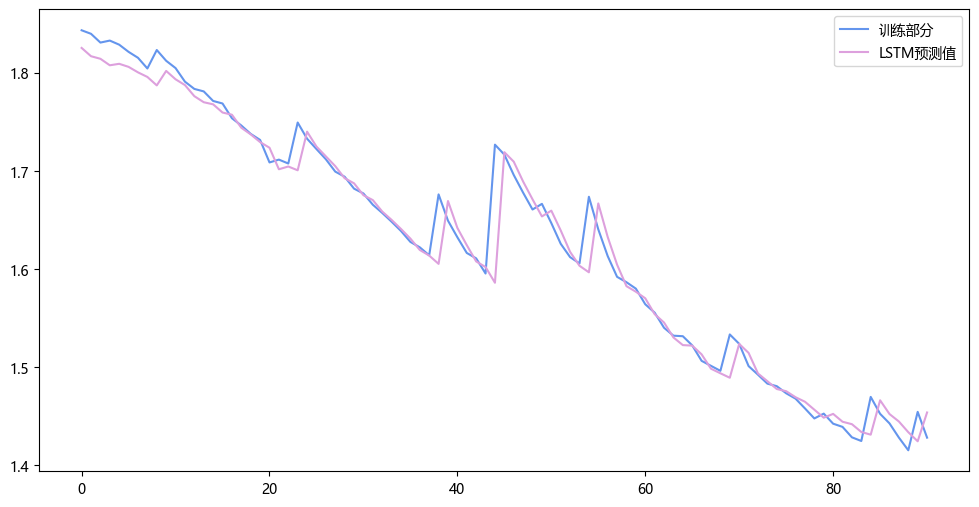

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('scaler')
train_data = scaler.inverse_transform(train_data)
train_pre_data = scaler.inverse_transform(train_pre_data)
# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(train_data, label='训练部分',color='cornflowerblue')  # 真实值
plt.plot(train_pre_data, label='LSTM预测值',color='plum')  # 预测值
plt.legend()
plt.show()

In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(train_data, train_pre_data)
print('训练集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
train_mse = mean_squared_error(train_data, train_pre_data)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train_data, train_pre_data)
print('训练数据集上的均方误差-MSE: ',train_mse)
print('训练数据集上的均方根误差-RMSE: ',train_rmse)
print('训练数据集上的平均绝对误差-MAE: ',train_mae)

训练集上 模型分数-R^2: 0.9667630953496977
**************************************************
训练数据集上的均方误差-MSE:  0.0005246375117225855
训练数据集上的均方根误差-RMSE:  0.02290496696619721
训练数据集上的平均绝对误差-MAE:  0.012753111837940916


### 第二部分，测试集可视化与评估

In [9]:
# 模型预测
# 模型 测试集 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_lstm.pt')
model = model.to(device)

# 预测数据
test_data = []
test_pre_data = []
with torch.no_grad():
        for data, label in test_loader:
            # 原始标签
            origin_lable = label.tolist()
            test_data += origin_lable
            model.eval()  # 将模型设置为评估模式
            
            # 预测
            data, label = data.to(device), label.to(device)
            test_pred = model(data)  # 对测试集进行预测
            test_pred = test_pred.tolist()
            test_pre_data += test_pred      

测试集可视化

c:\Users\许艺馨\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


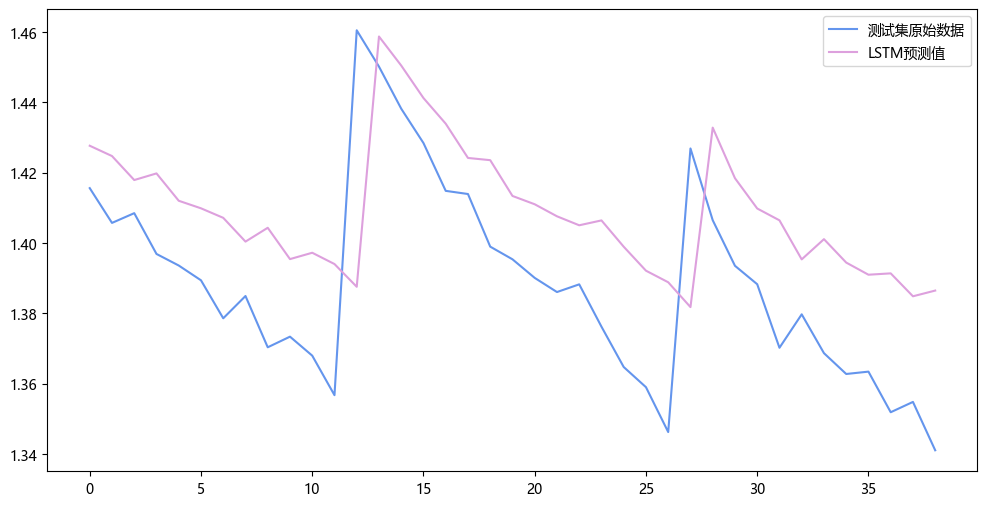

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('scaler')
test_data = scaler.inverse_transform(test_data)
test_pre_data = scaler.inverse_transform(test_pre_data)
# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_data, label='测试集原始数据',color='cornflowerblue')  # 真实值
plt.plot(test_pre_data, label='LSTM预测值',color='plum')  # 预测值
plt.legend()
plt.show()

In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(test_data, test_pre_data)
print('测试集 模型分数-R^2:',score)

print('*'*50)
# 测试集上的预测误差
test_mse = mean_squared_error(test_data, test_pre_data)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_data, test_pre_data)
print('测试数据集上的均方误差-MSE: ',test_mse)
print('测试数据集上的均方根误差-RMSE: ',test_rmse)
print('测试数据集上的平均绝对误差-MAE: ',test_mae)

测试集 模型分数-R^2: -0.08680130033200273
**************************************************
测试数据集上的均方误差-MSE:  0.0008406888375817672
测试数据集上的均方根误差-RMSE:  0.028994634634389983
测试数据集上的平均绝对误差-MAE:  0.026224029615987077


# 第三部分，整体效果

In [12]:
# 制作数据集和标签
import torch
import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from joblib import dump, load

# 读取数据
capacity = load('capacity')
# 取 B0005 数据
target_data = capacity['B0018'][1]
target_data = np.array(target_data) # 转换为numpy
target_data = target_data.reshape(-1, 1)
# 归一化处理
# 使用标准化（z-score标准化）
scaler = StandardScaler()
target_data = scaler.fit_transform(target_data)

# 这些转换是为了将数据和标签转换为PyTorch可以处理的张量
def make_data_labels(x_data, y_label):
    '''
        返回 x_data: 数据集     torch.tensor
            y_label: 对应标签值  torch.tensor
    '''
    # 信号值
    x_data = torch.tensor(x_data).float()
    # 标签值
    y_label = torch.tensor(y_label).float()
    return x_data, y_label


# 使用滑动窗口处理时间序列数据
def data_window_maker(time_series, window_size):
    '''
        参数:
        time_series: 风速数据集(为numpy数组格式)
        window_size: 滑动窗口大小
        ndim: 数组维度

        返回:
        data_x: 特征数据
        data_y: 标签数据
    '''
    # 用来存放输入特征
    data_x = []
    # 用来存放输出标签
    data_y = []
    # 构建训练集和对应标签
    data_len = time_series.shape[0]
    for i in range(data_len - window_size):
            data_x.append(time_series[i:i+window_size, :])  # 取前window_size个数据作为输入特征
            data_y.append(time_series[i+window_size, :])  # 取第window_size+1个数据作为输出标签
    

    # 将列表转换为单一的NumPy数组
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    # 转换为 tensor
    data_x, data_y = make_data_labels(data_x, data_y)
    return data_x, data_y


# 数据集制作
def make_wind_dataset(data, window_size):
    '''
        参数:
        data: 数据集(为numpy数组格式)
        window_size: 滑动窗口大小
    '''
    # 第二步，制作数据集标签  滑动窗口
    data_set, labels = data_window_maker(data, window_size)

    return data_set, labels

# 定义滑动窗口大小  和数据集制作中的一样
window_size = 1

# 制作数据集
data_set, labels = make_wind_dataset(target_data, window_size)

batch_size = 1 # 和最开始设置一样
# 加载数据
data_loader = Data.DataLoader(dataset=Data.TensorDataset(data_set, labels),
                                   batch_size=batch_size, num_workers=2, drop_last=True)


# 模型 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_lstm.pt')
model = model.to(device)

# 预测数据
origin_data = []
pre_data = []
with torch.no_grad():
        for data, label in data_loader:
            # 原始标签
            origin_lable = label.tolist()
            origin_data += origin_lable
            model.eval()  # 将模型设置为评估模式
            
            # 预测
            data, label = data.to(device), label.to(device)
            pred = model(data)  # 对测试集进行预测
            pred = pred.tolist()
            pre_data += pred        

c:\Users\许艺馨\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


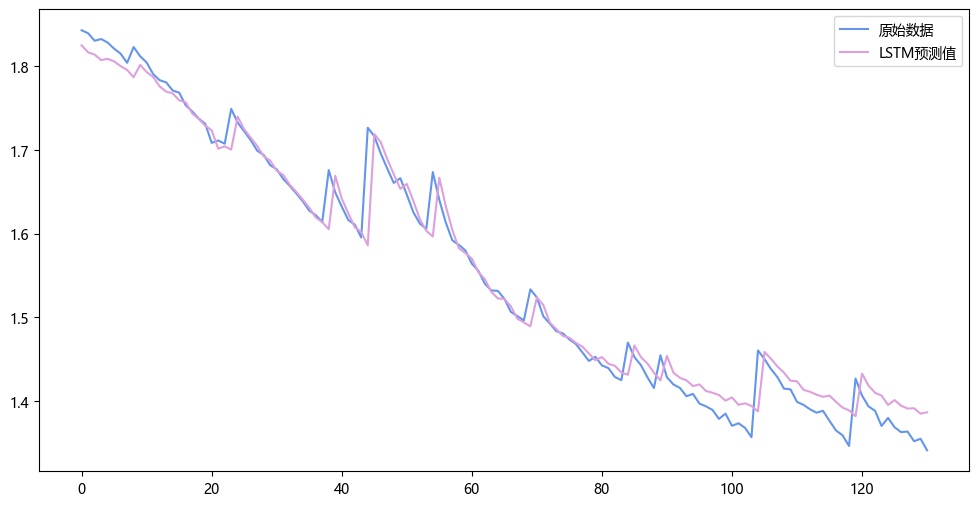

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('scaler')
origin_data = scaler.inverse_transform(origin_data)
pre_data = scaler.inverse_transform(pre_data)


# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(origin_data, label='原始数据',color='cornflowerblue')  # 真实值
plt.plot(pre_data, label='LSTM预测值',color='plum')  # 预测值
plt.legend()
plt.show()

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(origin_data, pre_data)
print('整体模型分数-R^2:',score)

print('*'*50)
# 预测误差
mse = mean_squared_error(origin_data, pre_data)
rmse = np.sqrt(mse)
mae = mean_absolute_error(origin_data, pre_data)
print('均方误差-MSE: ',mse)
print('均方根误差-RMSE: ',rmse)
print('平均绝对误差-MAE: ',mae)

整体模型分数-R^2: 0.9735621148972992
**************************************************
均方误差-MSE:  0.0006162502573517891
均方根误差-RMSE:  0.024824388358060084
平均绝对误差-MAE:  0.016774115463671108


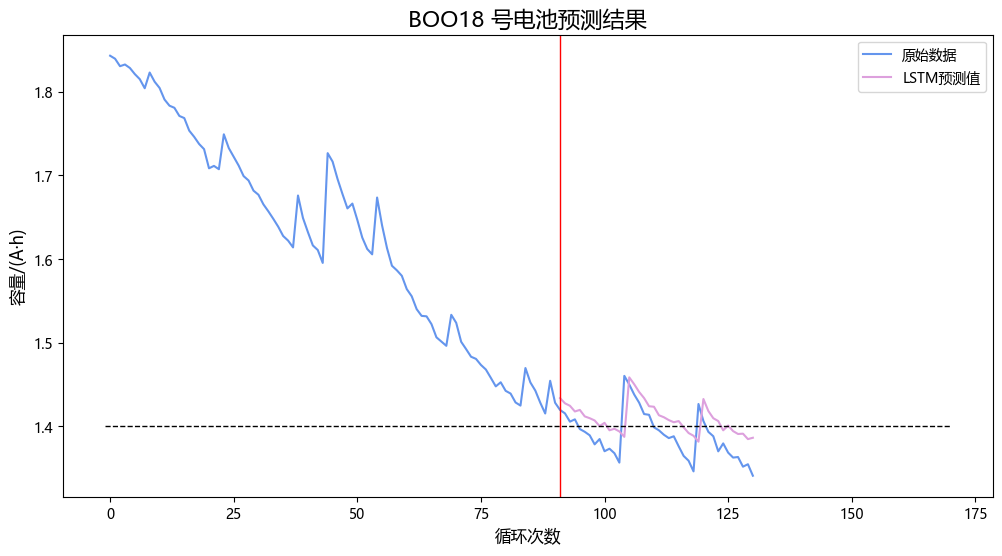

In [15]:
# 定义数据集制作中的参数   同 数据集制作中的参数
# 滑动窗口大小
window_size = 1
# 数据集划分比例
split_rate = [0.7, 0.3]
# 分割节点
split_index = int(len(origin_data)*split_rate[0])  # 向下取整
x = [x for x in range(split_index, len(pre_data))]

# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(origin_data, label='原始数据',color='cornflowerblue')  # 真实值
plt.plot(x, pre_data[split_index:, :], label='LSTM预测值',color='plum')  # 预测值


plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')  # 临界点直线  可自己调整位置
# 在 x=split_index 处添加一条红色的竖线
plt.axvline(x=split_index, color='red', lw=1, ls='-')  # 数据集划分竖线  可自己调整位置

plt.xlabel('循环次数', fontsize=12)
plt.ylabel('容量/(A·h)', fontsize=12)
plt.title('BOO18 号电池预测结果', fontsize=16)
plt.legend()
plt.show()